In [1]:
import xarray as xr
import xclim as xc
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import glob
import datetime

In [8]:
z500_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/zg500/zg500_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
z500_files.sort()

pr_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/pr/pr_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
pr_files.sort()

psl_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/psl/psl_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
psl_files.sort()

ua300_files = glob.glob('/g/data/yb19/australian-climate-service/release/ACS-BARRA2/output/AUS-11/BOM/ECMWF-ERA5/historical/hres/BOM-BARRA-R2/v1/day/ua300/ua300_AUS-11_ECMWF-ERA5_historical_hres_BOM-BARRA-R2_v1_day_*.nc')
ua300_files.sort()

In [9]:
z500_ds = xr.open_mfdataset(z500_files)
pr_ds = xr.open_mfdataset(pr_files)
psl_ds = xr.open_mfdataset(psl_files)
ua300_ds = xr.open_mfdataset(u300_files)

In [26]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_ylim(-55, 10)
    #ax.set_extent([-140, -60, 20, 70])
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
    plt.savefig(
        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=300
    )

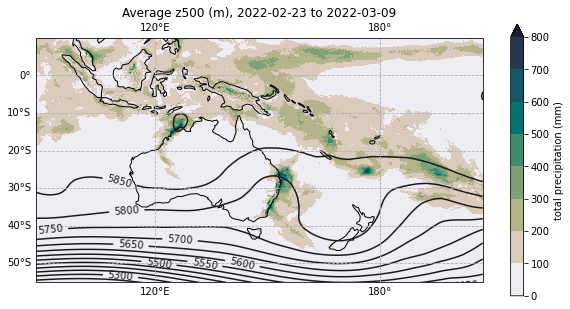

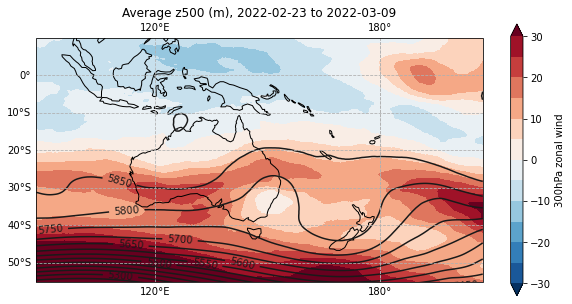

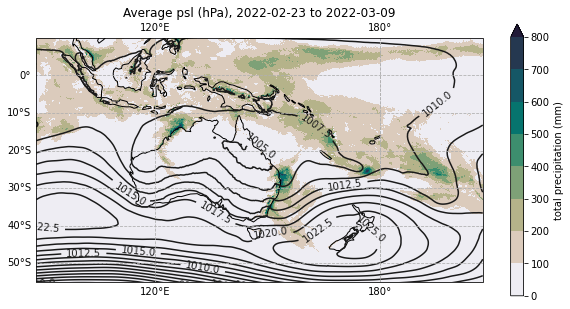

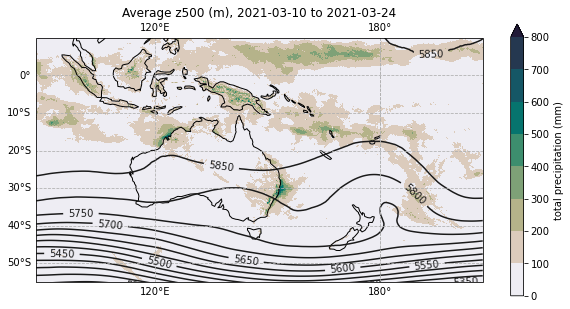

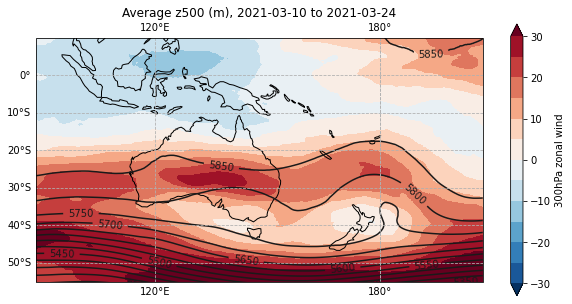

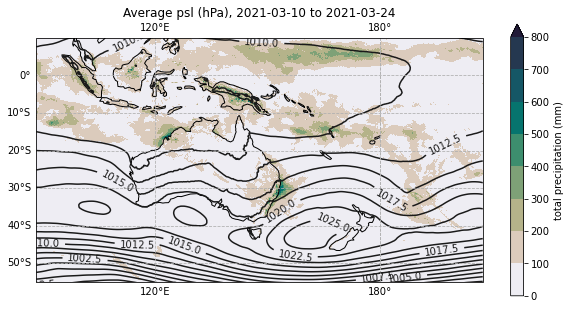

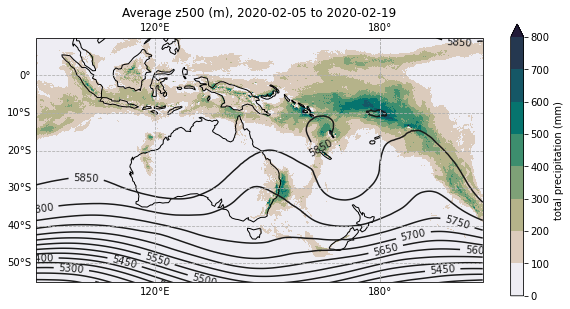

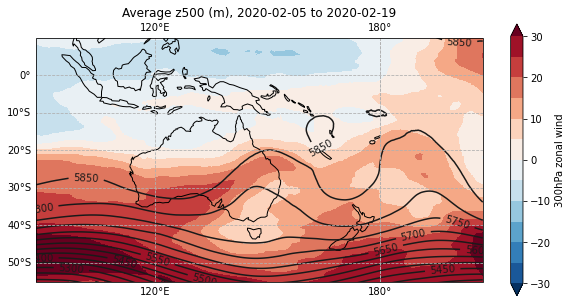

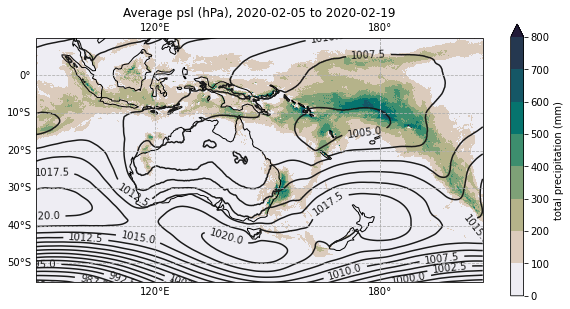

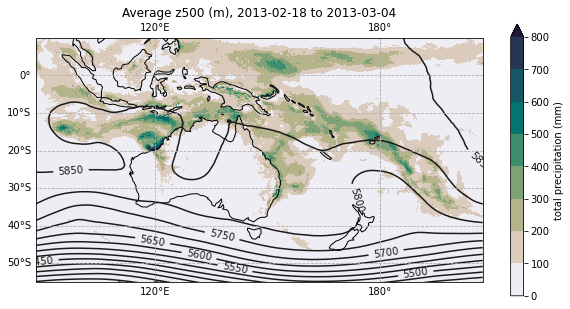

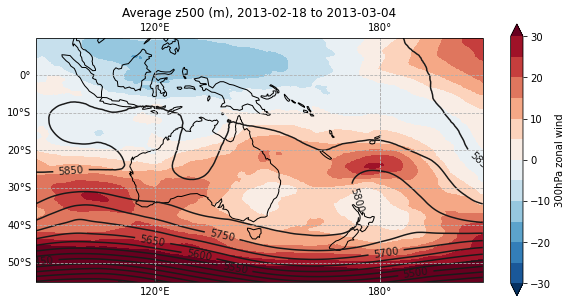

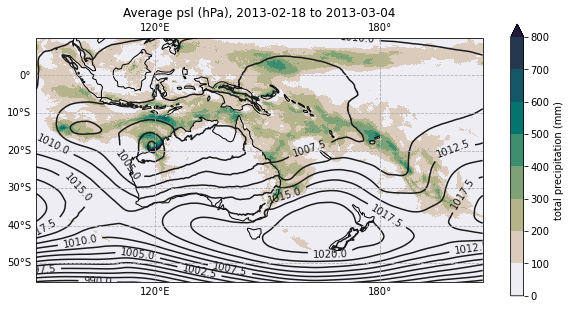

In [27]:
for end_date in ['2022-03-09', '2021-03-24', '2020-02-19', '2013-03-04']:
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    z500_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
    pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    ua300_da = ua300_ds.sel({'time': slice(start_date, end_date)})['ua300']
    
    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True)    
    
    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)

TODO: Add u300 contours (in blue) to the z500 plot to see if the subtropical jet is over Australia.

The mean z500 and mslp patterns for the highest ever rx15day event (ending on 2022-03-09 with a mean 15 day rainfall of 410mm; see above) are pretty distinct from (kind of a more extreme version of) the next 3 highest rx15day events in the record...
- 2nd: Event ending 2021-03-24, 288mm (has a similar mslp pattern to the record rx15day but not as much upper level support in the z500 field)
- 3rd: Event ending 2020-02-19; 288mm (compared to the record rx15day pattern the surface high over NZ is weaker / more diffuse but the upper level pattern is pretty similar)
- 4th: Event ending 2013-03-04; 285mm (the surface high is pretty similar to the record event - just a little weaker - but not as much upper level support in the z500 field) 

In [56]:
def plot_days(contour_var, start_date, end_date):
    """Plot days"""

    pr_da = pr_ds.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    
    if contour_var == 'z500':
        contour_da = z500_ds.sel({'time': slice(start_date, end_date)})['zg500']
    elif contour_var == 'psl':
        contour_da = psl_ds.sel({'time': slice(start_date, end_date)})['psl']
        contour_da = xc.units.convert_units_to(contour_da, 'hPa')
    else:
        raise ValueError('Invalid contour variable')
    
    fig = plt.figure(figsize=[20, 18])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 75)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 5)

    plot_order = [1, 4, 7, 10, 13, 2, 5, 8, 11, 14, 3, 6, 9, 12, 15]
    for day in range(15):
        ax = fig.add_subplot(5, 3, plot_order[day], projection=map_proj)
        pr_da.isel({'time': day}).plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap=cmocean.cm.rain,
            levels=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            extend='max',
            cbar_kwargs={'label': 'total precipitation (mm)'},
        )
    
        lines = contour_da.isel({'time': day}).plot.contour(
            ax=ax,
            transform=ccrs.PlateCarree(),
            levels=levels,
            colors=['0.1']
        )
        ax.clabel(lines, colors=['0.1'], manual=False, inline=True)
        ax.coastlines()
        ax.gridlines(linestyle='--', draw_labels=True)
        date = str(pr_da.isel({'time': day})['time'].dt.strftime('%d %b').values)
        ax.set_title(date)
        ax.set_ylim(-55, 10)
    plt.suptitle(f'Daily {contour_var} ({contour_da.units})')
    plt.savefig(
        f'{contour_var}_days_BARRA2_{start_date}_{end_date}.png',
        bbox_inches='tight',
        facecolor='white',
        dpi=300
    )

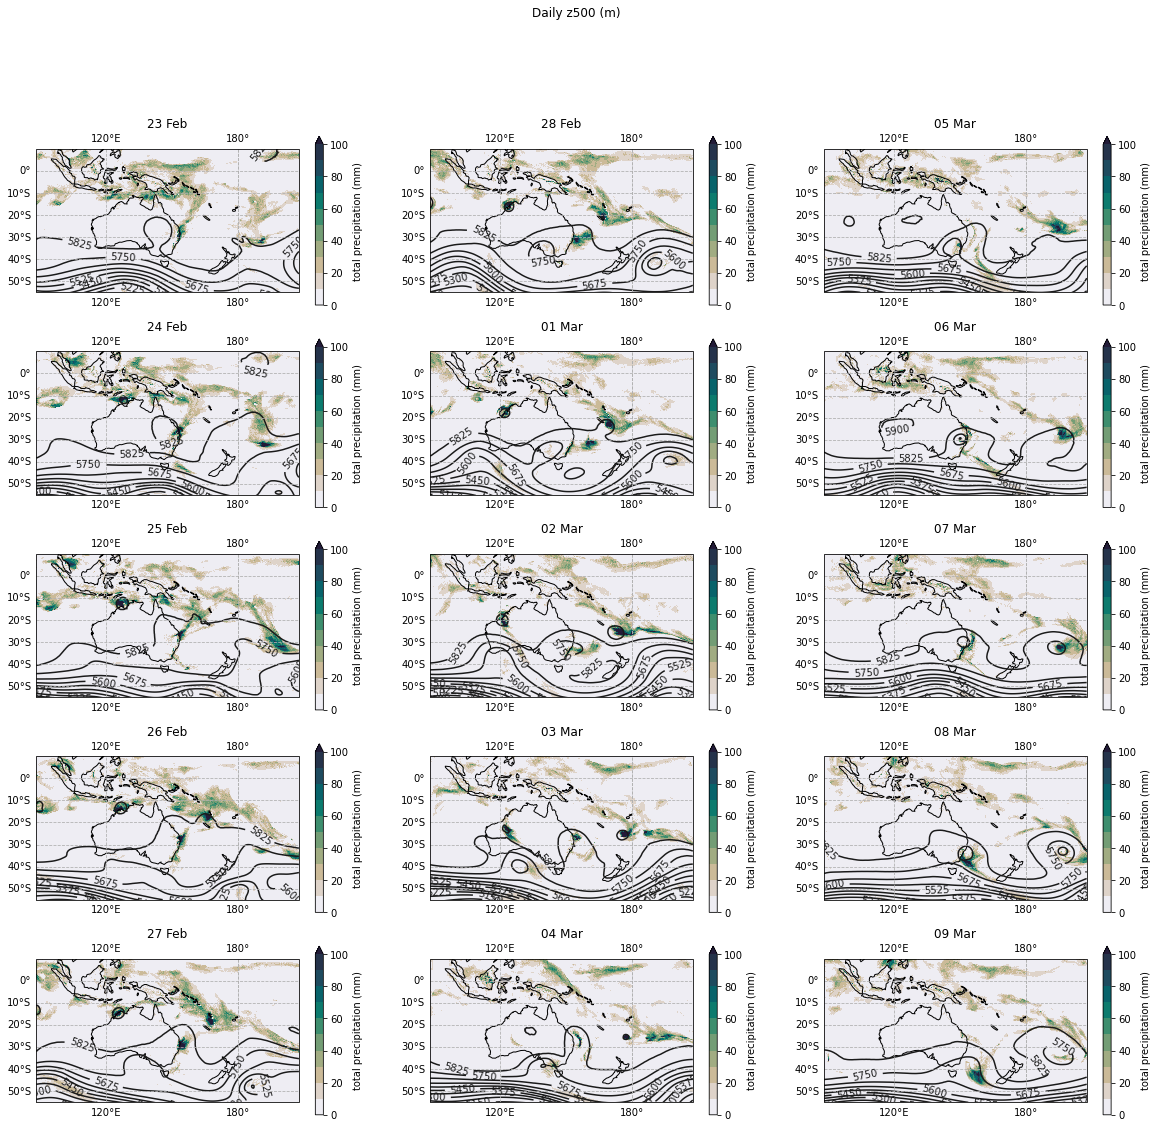

In [57]:
plot_days('z500', '2022-02-23', '2022-03-09')

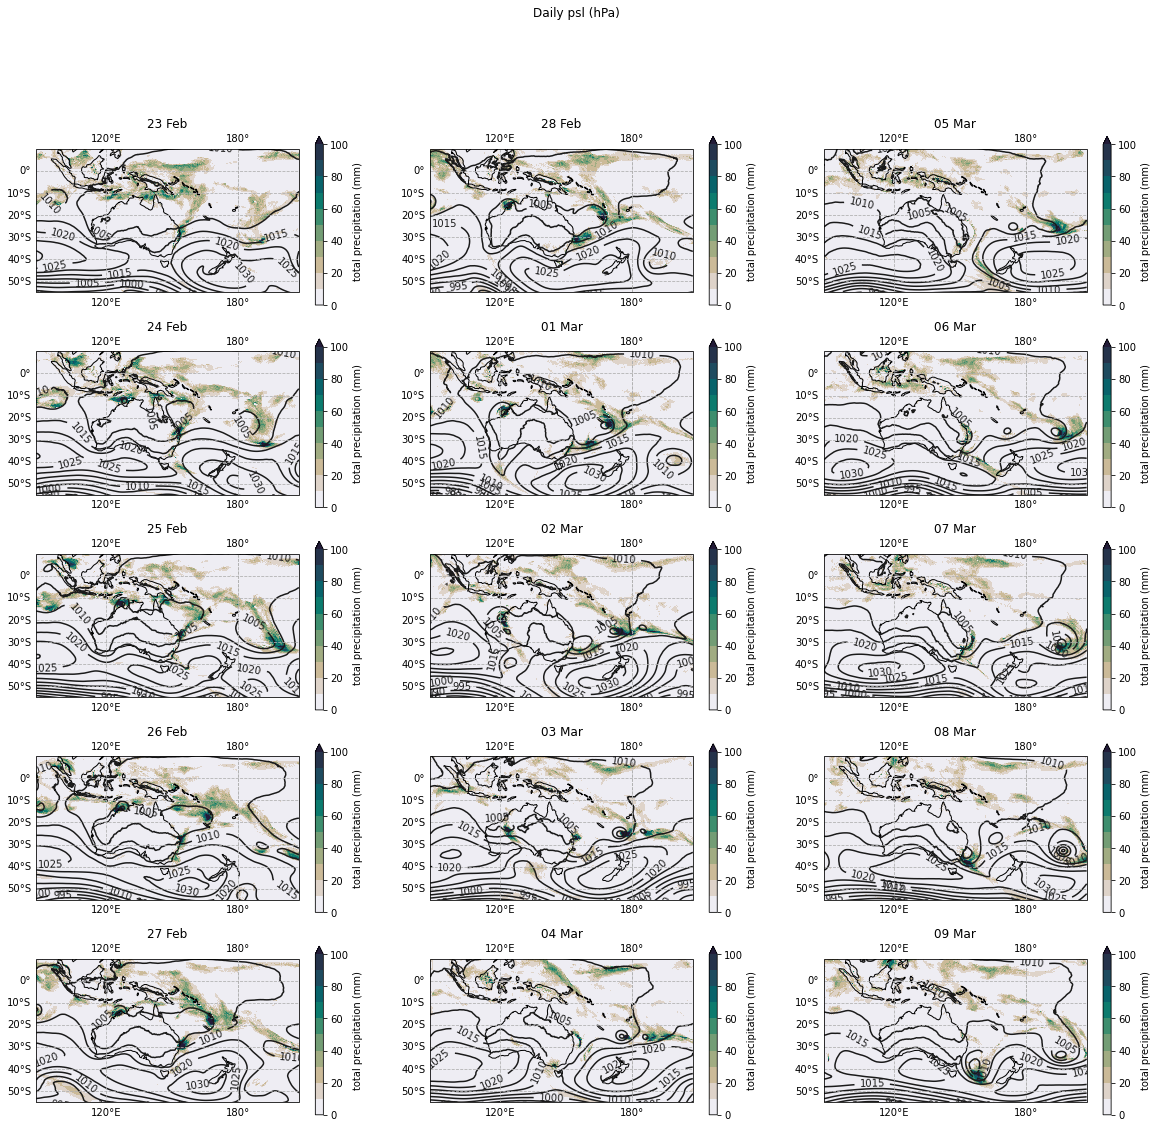

In [58]:
plot_days('psl', '2022-02-23', '2022-03-09')